In [1]:
import torch
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from numpy.random import randn
from numpy.random import randint
from itertools import product as pdt
# from src.assoc_utils_np import train_gcpc
# from src.assoc_utils_np_2D import gen_gbook_2d, path_integration_Wgg_2d, module_wise_NN_2d
# from src.seq_utils import *
plt.style.use('./src/presentation.mplstyle')

from tqdm import tqdm as tqdm
import scipy.io 
mat = scipy.io.loadmat('pos60by60.mat')
mat = scipy.io.loadmat('pos420by420.mat')
#mat = scipy.io.loadmat('pos585by585.mat')
hexgbook_map = mat["newpos"]

In [2]:
def flat_coord(coords,prodlambdas):
    x,y=coords
    return x+y*prodlambdas

def argmax2D(a):
    return np.unravel_index(a.argmax(), a.shape)

In [ ]:
from vectorhash import build_initializer, GridHippocampalScaffold, SoftmaxSmoothing

shapes = [(3,3),(5,5),(7,7)]
N_h=1200
device='cpu'

initializer, relu_theta, mean_h = build_initializer(
    shapes,
    initalization_method="by_sparsity",
    device=device,
)
scaffold = GridHippocampalScaffold(
    shapes=shapes,
    N_h=N_h,
    sparse_matrix_initializer=initializer,
    relu_theta=relu_theta,
    ratshift=False,
    sanity_check=False,
    calculate_g_method="hairpin",
    device=device,
    smoothing=SoftmaxSmoothing(T=1e-4),
)


module shapes:  [(3, 3), (5, 5), (7, 7)]
N_g     :  83
N_patts :  11025
N_h     :  1200


100%|██████████| 11025/11025 [00:01<00:00, 9266.82it/s]


In [4]:
gs=scaffold

In [5]:
#Noise in g and p layers, precomputed here for runtime efficiency, can be set to zero
#Noise in g and p layers, precomputed here for runtime efficiency, can be set to zero
n1=0.05*np.random.normal(0,1,gs.G.T.shape)
n2=0*0.05*np.random.normal(0,1,gs.H.T.shape)

In [6]:
cell_idxg1,cell_idxg2=np.random.randint(25,50),np.random.randint(25,50)
cell_idxp1,cell_idxp2=np.random.randint(0,gs.N_h),np.random.randint(0,gs.N_h)

n1 = torch.from_numpy(n1).float().to(device)
n2 = torch.from_numpy(n2).float().to(device)

In [7]:
gnoisy = gs.G.T +n1
avg_fieldsg1 = gnoisy[cell_idxg1].cpu().numpy()
avg_fieldsg2 = gnoisy[cell_idxg2].cpu().numpy()

pnoisy = gs.H.T+ n2
avg_fieldsp1 = pnoisy[cell_idxp1].cpu().numpy()
avg_fieldsp2 = pnoisy[cell_idxp2].cpu().numpy()

/tmp/ipykernel_3237/1900087205.py:47: RuntimeWarning: invalid value encountered in divide
  gc_tuning1 = smooth_tuningcurve(np.where(cntr>0,gc_1/cntr,np.nan), Npos)
/tmp/ipykernel_3237/1900087205.py:48: RuntimeWarning: invalid value encountered in divide
  gc_tuning2 = smooth_tuningcurve(np.where(cntr>0,gc_2/cntr,np.nan), Npos)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generi

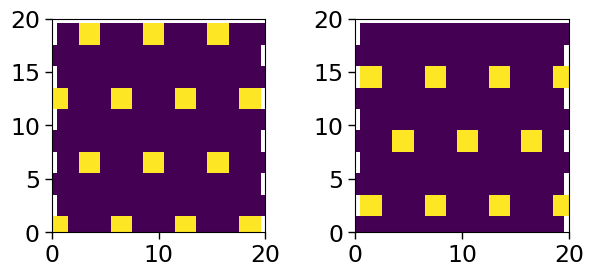

In [8]:
from vectorhash_imported import *
from vectorhash_functions import *
#Create path in LxL room and compute tuning curves of two cells
Npos = int(math.sqrt(gs.N_patts))
gbook = gs.G.T.view(gs.N_g, Npos, Npos)

T=5000
L=10
path = np.zeros((T,2))
init = (5,5)
path[0] = init
allowed_vs = [(0,1),(1,1),(1,0),(0,-1),(-1,-1),(-1,0)]
for t in range(1,T):
    next_step = -1,-1
    while not ((0<=next_step[0]+0.5*next_step[1]<L)*(0<=next_step[1]<L)):
        v = allowed_vs[np.random.randint(6)]
        next_step = path[t-1]+v
    path[t]=next_step



path_loc = path.astype('int')
gbook_loc = np.copy(path_loc)
gc_1 = np.zeros((Npos,Npos))
cntr = np.zeros((Npos,Npos))
gc_2 = np.zeros((Npos,Npos))
# gbook[:, a, b] = grid vector at position (a, b)

for t in []:
# for t in range(10,T,100):
    rand_v = allowed_vs[np.random.randint(6)]
    gbook_loc[t:] = gbook_loc[t:]+rand_v

for t in range(T):
    # if (t < 100):
        # gbook: (Ng, Npos, Npos)
        # print(gbook_loc[t][0], gbook_loc[t][1])
        # print("0", gbook[0][gbook_loc[t][0],gbook_loc[t][1]])
        # print("1", gbook[1][gbook_loc[t][0],gbook_loc[t][1]])
    

    gc_1[path_loc[t][0],path_loc[t][1]]+= gbook[0][gbook_loc[t][0],gbook_loc[t][1]]
    gc_2[path_loc[t][0],path_loc[t][1]]+= gbook[1][gbook_loc[t][0],gbook_loc[t][1]]
    cntr[path_loc[t][0],path_loc[t][1]]+=1

#smooth_tuningcurve function takes array and coverts it to offset rows to mimic a hexagonal lattice
gc_tuning1 = smooth_tuningcurve(np.where(cntr>0,gc_1/cntr,np.nan), Npos)
gc_tuning2 = smooth_tuningcurve(np.where(cntr>0,gc_2/cntr,np.nan), Npos)
# gc_tuning1 = smooth_tuningcurve(np.where(cntr_1>0,gc_1/cntr_1,0), Npos)
plt.subplots(1,2)
plt.subplot(121)
plt.imshow(gc_tuning1);
plt.xlim(0,20)
plt.ylim(0,20)
plt.subplot(122)
plt.imshow(gc_tuning2);
# plt.colorbar()
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()

(0.0, 200.0)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

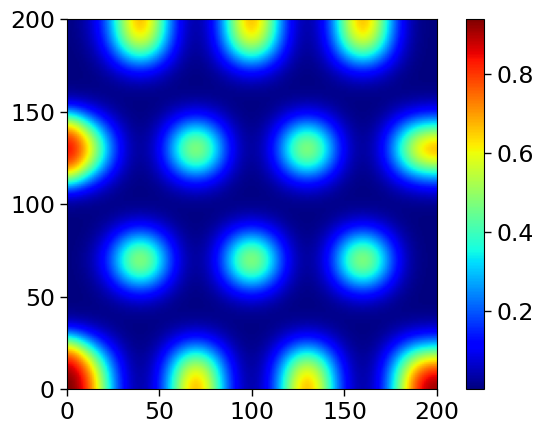

In [9]:
#Hexagonal lattice from smooth_tuningcurve above can be interpolated to obtain tuning curves
gct1 = explicit_interpolation(gc_tuning1[:20,:20], sigma=10)
gct2 = explicit_interpolation(gc_tuning2[:20,:20], sigma=10)
plt.imshow(gct1,cmap='jet');
plt.colorbar()
plt.xlim(0,200)
plt.ylim(0,200)

In [10]:
##Generate smooth interpolation across all grid states rather than having to run 
#interpolation for tuning curves in each room separately. Not necessary to do.
hexed_afs = smooth_tuningcurve(avg_fieldsg1, Npos)
hexed_afs_up_smooth = explicit_interpolation(hexed_afs, sigma=10)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

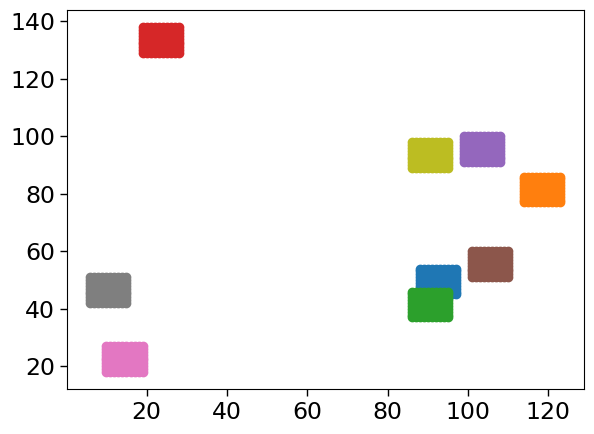

In [11]:
## Create some random rooms for visualization
Nposlin = 4*5*7
xs= np.random.randint(0,Nposlin - 10,9)
ys= np.random.randint(0,Nposlin - 10,9)

room_coords_tuple = [0]*9
room_coords_flat = [0]*9
for i in range(9):
    room_coords_tuple[i]=list(pdt(np.arange(xs[i],xs[i]+10),np.arange(ys[i],ys[i]+10)))
    room_coords_flat[i] = list(map(lambda x: flat_coord(x,Nposlin),room_coords_tuple[i]))
  
rct = np.array(room_coords_tuple)
rcf = np.array(room_coords_flat)

rcf = rcf.flatten()

for i in range(9):
    x_val = [x[0] for x in room_coords_tuple[i]]
    y_val = [x[1] for x in room_coords_tuple[i]]
    plt.scatter(x_val,y_val);
plt.show()

/tmp/ipykernel_3237/582860132.py:4: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[i//3,i%3].imshow(hexed_afs_up_smooth[20*xs[i]:20*xs[i]+200,20*ys[i]:20*ys[i]+200],cmap='jet',vmin=0,vmax=0.75);
/tmp/ipykernel_3237/582860132.py:4: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[i//3,i%3].imshow(hexed_afs_up_smooth[20*xs[i]:20*xs[i]+200,20*ys[i]:20*ys[i]+200],cmap='jet',vmin=0,vmax=0.75);


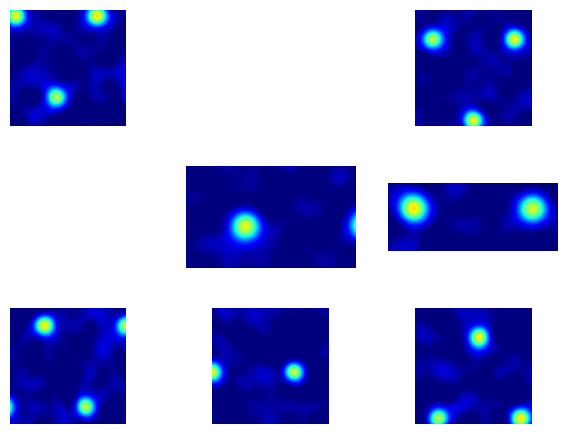

In [12]:
#Create example fields
fi,ax = plt.subplots(nrows=3,ncols=3)
for i in range(9):
        ax[i//3,i%3].imshow(hexed_afs_up_smooth[20*xs[i]:20*xs[i]+200,20*ys[i]:20*ys[i]+200],cmap='jet',vmin=0,vmax=0.75);
        ax[i//3,i%3].set_axis_off()
plt.subplots_adjust(wspace=0, hspace=0)

In [13]:
#Create tuning curves for two grid cells in the 3 rooms

hexed_afs_g1 = smooth_tuningcurve(avg_fieldsg1, Npos)
hexed_afs_g2 = smooth_tuningcurve(avg_fieldsg2, Npos)

rm1_g1 = hexed_afs_g1[20:40,20:40]
rm2_g1 = hexed_afs_g1[2:22,37:57]
rm3_g1 = hexed_afs_g1[73:93, 8:28]
rm1_g2 = hexed_afs_g2[20:40,20:40]
rm2_g2 = hexed_afs_g2[2:22,37:57]
rm3_g2 = hexed_afs_g2[73:93, 8:28]

In [14]:
hexed_afs_g1 = smooth_tuningcurve(avg_fieldsg1, Npos)
hexed_afs_up_smooth_g1 = explicit_interpolation(hexed_afs_g1, sigma=10)
hexed_afs_g2 = smooth_tuningcurve(avg_fieldsg2, Npos)
hexed_afs_up_smooth_g2 = explicit_interpolation(hexed_afs_g2, sigma=10)

rm1_g1 = hexed_afs_up_smooth_g1[200:400,200:400]
rm2_g1 = hexed_afs_up_smooth_g1[19:219,370:570]
rm3_g1 = hexed_afs_up_smooth_g1[726:926, 83:283]
rm1_g2 = hexed_afs_up_smooth_g2[200:400,200:400]
rm2_g2 = hexed_afs_up_smooth_g2[19:219,370:570]
rm3_g2 = hexed_afs_up_smooth_g2[726:926, 83:283]

In [15]:
##Tuning curve cross correlation
rm1_g1_g2 = scipy.signal.correlate(rm1_g1,rm1_g2)
rm2_g1_g2 = scipy.signal.correlate(rm2_g1,rm2_g2)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

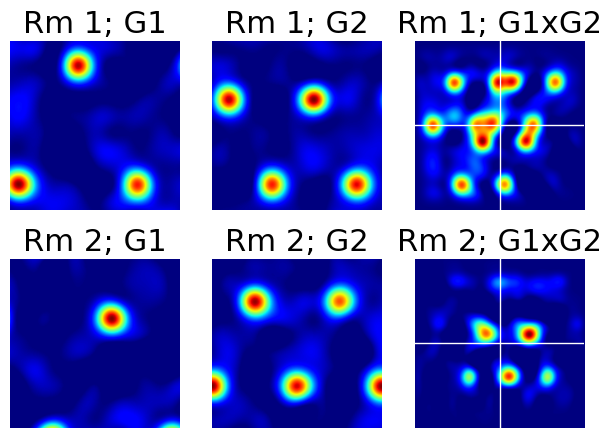

In [16]:
##Plot tuning curves and cross correlations
# plt.imshow(rm1,cmap='jet',vmin=0)
fi,ax = plt.subplots(nrows=2,ncols=3)
ax[0,0].imshow(rm1_g1,cmap='jet',vmin=0)
ax[0,0].set_axis_off()
ax[0,0].set_title('Rm 1; G1');
ax[0,1].imshow(rm1_g2,cmap='jet',vmin=0)
ax[0,1].set_axis_off()
ax[0,1].set_title('Rm 1; G2');

scalef=1
ax[0,2].imshow(rm1_g1_g2,cmap='jet',vmin=0)
ax[0,2].plot([0,399/scalef],[200/scalef,200/scalef],'w');
ax[0,2].plot([200/scalef,200/scalef],[0,399/scalef],'w');
ax[0,2].set_axis_off()
ax[0,2].set_xlim(0,399/scalef);
ax[0,2].set_ylim(0,399/scalef);
ax[0,2].set_title('Rm 1; G1xG2');
# plt.show()

ax[1,0].imshow(rm2_g1,cmap='jet',vmin=0)
ax[1,0].set_axis_off()
ax[1,0].set_title('Rm 2; G1');
ax[1,1].imshow(rm2_g2,cmap='jet',vmin=0)
ax[1,1].set_axis_off()
ax[1,1].set_title('Rm 2; G2');

ax[1,2].imshow(rm2_g1_g2,cmap='jet',vmin=0)
ax[1,2].plot([0,399],[200/scalef,200/scalef],'w');
ax[1,2].plot([200/scalef,200/scalef],[0,399/scalef],'w');
ax[1,2].set_axis_off()
ax[1,2].set_xlim(0,399/scalef);
ax[1,2].set_ylim(0,399/scalef);
ax[1,2].set_title('Rm 2; G1xG2');

# plt.savefig('Grid_correlation_preserved_across_rooms.pdf')
plt.show()


In [17]:
#Create tuning curves for two hippocampal cells in the 3 rooms

print(avg_fieldsp1.shape)
hexed_afs_p1 = smooth_tuningcurve(avg_fieldsp1, Npos)
hexed_afs_p2 = smooth_tuningcurve(avg_fieldsp2, Npos)

# rm1_p1 = hexed_afs_p1[20:40,20:40]
# rm2_p1 = hexed_afs_p1[2:22,37:57]
# rm3_p1 = hexed_afs_p1[73:93, 8:28]
# rm1_p2 = hexed_afs_p2[20:40,20:40]
# rm2_p2 = hexed_afs_p2[2:22,37:57]
# rm3_p2 = hexed_afs_p2[73:93, 8:28]s

(11025,)


In [18]:
hexed_afs_p1 = smooth_tuningcurve(avg_fieldsp1, Npos)
hexed_afs_up_smooth_p1 = explicit_interpolation(hexed_afs_p1, sigma=10)
hexed_afs_p2 = smooth_tuningcurve(avg_fieldsp2, Npos)
hexed_afs_up_smooth_p2 = explicit_interpolation(hexed_afs_p2, sigma=10)

rm1_p1 = hexed_afs_up_smooth_p1[200:400,200:400]
rm2_p1 = hexed_afs_up_smooth_p1[19:219,370:570]
rm3_p1 = hexed_afs_up_smooth_p1[726:926, 83:283]
rm1_p2 = hexed_afs_up_smooth_p2[200:400,200:400]
rm2_p2 = hexed_afs_up_smooth_p2[19:219,370:570]
rm3_p2 = hexed_afs_up_smooth_p2[726:926, 83:283]

In [19]:
#Create cross correlation of tuning curves
rm1_p1_p2 = scipy.signal.correlate(rm1_p1,rm1_p2)
rm2_p1_p2 = scipy.signal.correlate(rm2_p1,rm2_p2)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

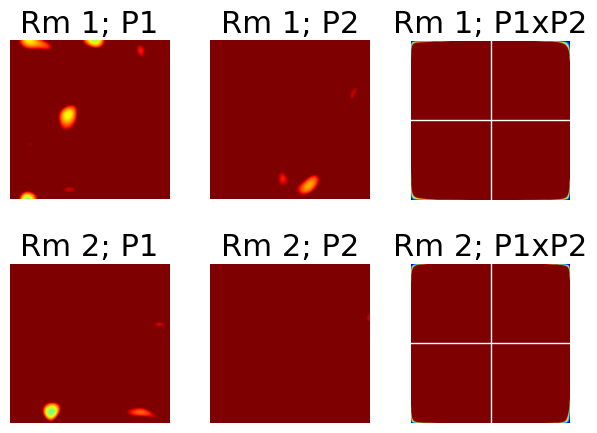

In [20]:
#Plot tuning curves and cross correlations
# plt.imshow(rm1,cmap='jet',vmin=0)
fi,ax = plt.subplots(nrows=2,ncols=3)
t1 = ax[0,0].imshow(rm1_p1,cmap='jet',vmin=0,vmax=1)
# plt.colorbar(t1,ax=ax[0,0],fraction=0.025)
ax[0,0].set_axis_off()
ax[0,0].set_title('Rm 1; P1');
t2=ax[0,1].imshow(rm1_p2,cmap='jet',vmin=0,vmax=1)
# plt.colorbar(t2,ax=ax[0,1],fraction=0.025)
ax[0,1].set_axis_off()
ax[0,1].set_title('Rm 1; P2');

scalef=1
t3=ax[0,2].imshow(rm1_p1_p2,cmap='jet',vmin=0,vmax=275)
ax[0,2].plot([0,399/scalef],[200/scalef,200/scalef],'w');
ax[0,2].plot([200/scalef,200/scalef],[0,399/scalef],'w');
ax[0,2].set_axis_off()
ax[0,2].set_xlim(0,399/scalef);
ax[0,2].set_ylim(0,399/scalef);
# plt.colorbar(t3,ax=ax[0,2],fraction=0.025)
ax[0,2].set_title('Rm 1; P1xP2');
# plt.show()

ax[1,0].imshow(rm2_p1,cmap='jet',vmin=0,vmax=0.75)
ax[1,0].set_axis_off()
ax[1,0].set_title('Rm 2; P1');
ax[1,1].imshow(rm2_p2,cmap='jet',vmin=0,vmax=0.75)
ax[1,1].set_axis_off()
ax[1,1].set_title('Rm 2; P2');

ax[1,2].imshow(rm2_p1_p2,cmap='jet',vmin=0,vmax=250)
ax[1,2].plot([0,399],[200/scalef,200/scalef],'w');
ax[1,2].plot([200/scalef,200/scalef],[0,399/scalef],'w');
ax[1,2].set_axis_off()
ax[1,2].set_xlim(0,399/scalef);
ax[1,2].set_ylim(0,399/scalef);
ax[1,2].set_title('Rm 2; P1xP2');

plt.savefig('Place_correlation_preserved_across_rooms.pdf')
plt.show()


In [21]:
Np = gs.N_h
#Check fraction of grid place co-activation in Vector-HASH
gmatch = np.zeros((gs.N_g,gs.N_h,2))-1
gcntr=np.zeros((2,2))
pbook = gs.H.T.reshape(gs.N_h,Npos, Npos).unsqueeze(0).cpu().numpy()
for gi in range(gs.N_g):
    for pi in range(Np):
        p1=pbook[0,pi][0:10,0:10]
        g1=gbook[gi][0:10,0:10]
        p2=pbook[0,pi][60:70,30:40]
        g2=gbook[gi][60:70,30:40]
        
        pmax = argmax2D(p1)
        if p1[pmax]<0.2:
            continue
        gtmp1 = g1[pmax]
        pmax = argmax2D(p2)
        if p2[pmax]<0.2:
            continue
        gtmp2 = g2[pmax]
        gmatch[gi,pi] = gtmp1,gtmp2
        if gtmp1>=0:
            gcntr[int(gtmp1),int(gtmp2)] += 1

In [22]:
true_both = gcntr/np.sum(gcntr)
print(true_both[1,1])

0.009196787148594378


In [23]:
#Check fraction of grid place co-activation when place fields are shuffled. Repeat over 100 shuffles
shuf_both = []
for _ in tqdm(range(100)):
    pshuffle = np.random.permutation(pbook.flatten()).reshape((1,Np,Npos,Npos))
    gmatch = np.zeros((gs.N_g,Np,2))-1
    gcntr_shuf=np.zeros((2,2))
    for gi in range(gs.N_g):
        for pi in range(Np):
            p1=pshuffle[0,pi][0:10,0:10]
            g1=gbook[gi][0:10,0:10]
            p2=pshuffle[0,pi][60:70,30:40]
            g2=gbook[gi][60:70,30:40]

            pmax = argmax2D(p1)
            if p1[pmax]<0.2:
                continue
            gtmp1 = g1[pmax]
            pmax = argmax2D(p2)
            if p2[pmax]<0.2:
                continue
            gtmp2 = g2[pmax]
            gmatch[gi,pi] = gtmp1,gtmp2
            if gtmp1>=0:
                gcntr_shuf[int(gtmp1),int(gtmp2)] += 1

    shuf_both.append((gcntr_shuf/np.sum(gcntr_shuf))[1,1])

100%|██████████| 100/100 [09:58<00:00,  5.98s/it]


Text(0, 0.5, 'PDF')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

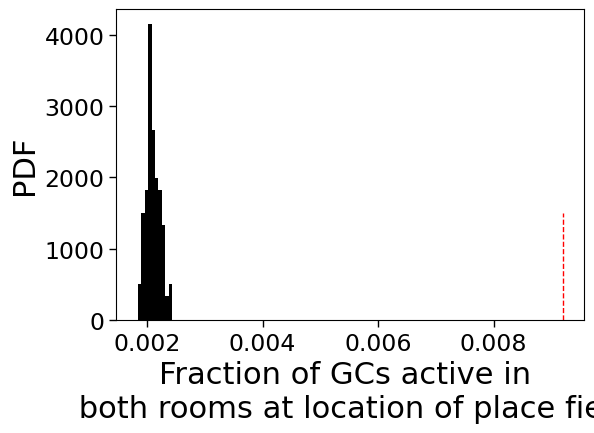

In [24]:
plt.hist(shuf_both,density=True, color='k');
plt.plot([true_both[1,1],true_both[1,1]],[0,1500], 'r--')
plt.xlabel('Fraction of GCs active in \n both rooms at location of place field')
plt.ylabel('PDF')
# plt.savefig('gc_fraction_at_place_field_locs.pdf')

In [25]:
def explicit_interpolation_new(hexed_afs, upsample_rate=10, sigma=10,thresh=0.1):
    hexed_afs_up = upsample(hexed_afs, upsample_rate)

    U=hexed_afs_up.copy()
    U[np.isnan(hexed_afs_up)]=0
    UU=gaussian_filter(U,sigma=sigma)#,mode='constant',cval=0)

    W=0*hexed_afs_up.copy()+1
    W[np.isnan(hexed_afs_up)]=0
    WW=gaussian_filter(W,sigma=sigma)#,mode='constant',cval=0)
    WW[WW<thresh]=0

    hexed_afs_up_smooth=UU/WW
    return hexed_afs_up_smooth

In [26]:
T=100
L=10
path = np.zeros((T,2))
init = (np.random.randint(0,L),np.random.randint(0,L))
path[0] = init
allowed_vs = [(0,1),(1,1),(1,0),(0,-1),(-1,-1),(-1,0)]
for t in range(1,T):
    next_step = -1,-1
    while not ((0<=next_step[0]+0.5*next_step[1]<L)*(0<=next_step[1]<L)):
        v = allowed_vs[np.random.randint(6)]
        next_step = path[t-1]+v
    path[t]=next_step



path_loc = path.astype('int')
gbook_loc = np.copy(path_loc)
gc_1 = np.zeros((Npos,Npos))
cntr = np.zeros((Npos,Npos))
gc_2 = np.zeros((Npos,Npos))
gidx=20#17#12
for t in range(T):
    gc_1[path_loc[t][0],path_loc[t][1]]+= gbook[gidx][gbook_loc[t][0],gbook_loc[t][1]]
    cntr[path_loc[t][0],path_loc[t][1]]+=1

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

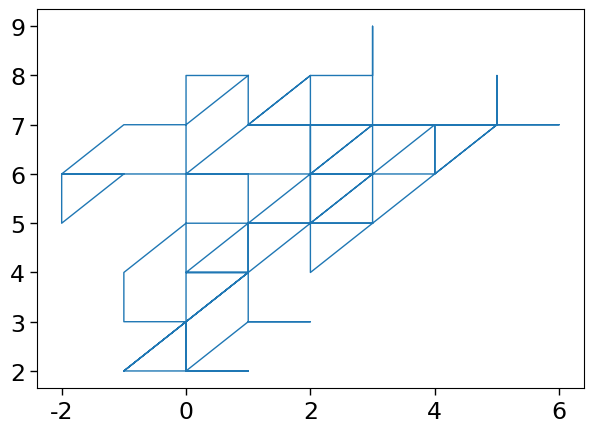

In [27]:
plt.plot(*path_loc.T)

/tmp/ipykernel_3237/3083554109.py:2: RuntimeWarning: invalid value encountered in divide
  gc_tuning1 = smooth_tuningcurve(np.where(cntr>0,gc_1/cntr,np.nan), Npos, path=True, path_locations=path_loc)
/tmp/ipykernel_3237/2524623782.py:13: RuntimeWarning: divide by zero encountered in divide
  hexed_afs_up_smooth=UU/WW
/tmp/ipykernel_3237/2524623782.py:13: RuntimeWarning: invalid value encountered in divide
  hexed_afs_up_smooth=UU/WW


(0.0, 200.0)

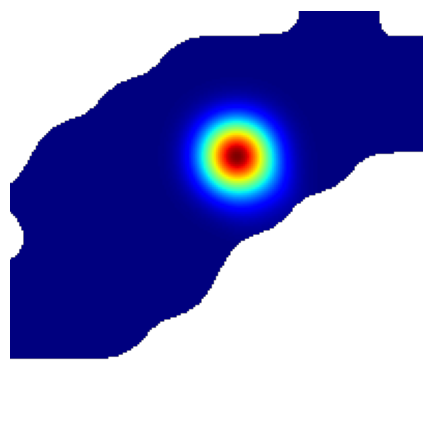

In [28]:
# gc_tuning1 = smooth_tuningcurve(np.where(cntr>0,gc_1/cntr,np.nan), Npos)
gc_tuning1 = smooth_tuningcurve(np.where(cntr>0,gc_1/cntr,np.nan), Npos, path=True, path_locations=path_loc)
gc_tuning1_smooth = explicit_interpolation_new(gc_tuning1[:20,:20], sigma=10, thresh=0.2)
# plt.imshow(gc_tuning1,cmap='jet');
plt.imshow(gc_tuning1_smooth,cmap='jet');
plt.axis('off')
plt.xlim(0,200)
plt.ylim(0,200)
# plt.savefig('tuning_curve_short_path_for_fyhn.pdf')